<a href="https://colab.research.google.com/github/amosmeireles/Problema-da-Mochila/blob/main/Problema_da_mochila.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Disciplina: OTIMIZAÇÃO DE SISTEMAS**

**Codigo da turma: 962-94349**

**Nome: Amós Meireles Diniz, Matricula: 2021101198**

#**Codigo para maximizar uma carteira de investimento utilizando o problema da mochila.**

In [ ]:
pip install numpy pandas scipy yfinance matplotlib seaborn

### Passo 1: Coleta de Dados dos Ativos com yfinance

In [11]:
import yfinance as yf

# Definir os ativos que você quer incluir na carteira
ativos = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']

# Baixar os dados de preço ajustado (fechamento) dos ativos
dados = yf.download(ativos, start='2020-01-01', end='2023-01-01')['Adj Close']

# Calcular os retornos diários dos ativos
retornos_diarios = dados.pct_change().dropna()


[*********************100%***********************]  5 of 5 completed


## Passo 2: Cálculo de Retorno Esperado e Risco (Volatilidade)

In [12]:
# Cálculo do retorno esperado anualizado (média dos retornos diários multiplicada por 252 dias úteis no ano)
retorno_esperado = retornos_diarios.mean() * 252

# Cálculo da volatilidade anualizada (desvio padrão dos retornos diários multiplicado pela raiz quadrada de 252)
volatilidade = retornos_diarios.std() * np.sqrt(252)


## Passo 3: Definir a Função Objetivo para a Otimização

In [13]:
# Função objetivo: maximizar o retorno esperado (ou minimizar o retorno negativo)
def funcao_objetivo(pesos, retorno_esperado):
    return -np.dot(pesos, retorno_esperado)


## Passo 4: Definir a Restrição de Risco

In [14]:
# Função de restrição: o risco não pode exceder o limite de risco máximo tolerado
def restricao_risco(pesos, cov_matrix, risco_maximo):
    risco_portfolio = np.sqrt(np.dot(pesos.T, np.dot(cov_matrix, pesos)))
    return risco_maximo - risco_portfolio

## Passo 5: Configurar a Otimização

In [15]:
# Configurações iniciais
cov_matrix = retornos_diarios.cov() * 252  # Matriz de covariância anualizada
risco_maximo = 0.20  # Exemplo: limite de risco de 20% anual

# Inicializar pesos iguais para todos os ativos
pesos_iniciais = np.ones(len(ativos)) / len(ativos)

# Definir limites para os pesos (entre 0 e 100% para cada ativo)
limites = [(0, 1) for _ in range(len(ativos))]

# Definir as restrições: a soma dos pesos deve ser 1 (100%) e o risco deve ser <= risco_maximo
restricoes = [
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Soma dos pesos = 1
    {'type': 'ineq', 'fun': lambda x: restricao_risco(x, cov_matrix, risco_maximo)}  # Risco <= risco_maximo
]

## Passo 6: Executar a Otimização

In [16]:
from scipy.optimize import minimize

# Resolver o problema de otimização
resultado = minimize(
    funcao_objetivo, pesos_iniciais, args=(retorno_esperado,),
    method='SLSQP', bounds=limites, constraints=restricoes
)

# Obter os pesos ótimos (alocação de ativos)
pesos_otimos = resultado.x


##Passo 7: Visualização dos Resultados

### 1. Gráfico de barras para mostrar a alocação dos ativos

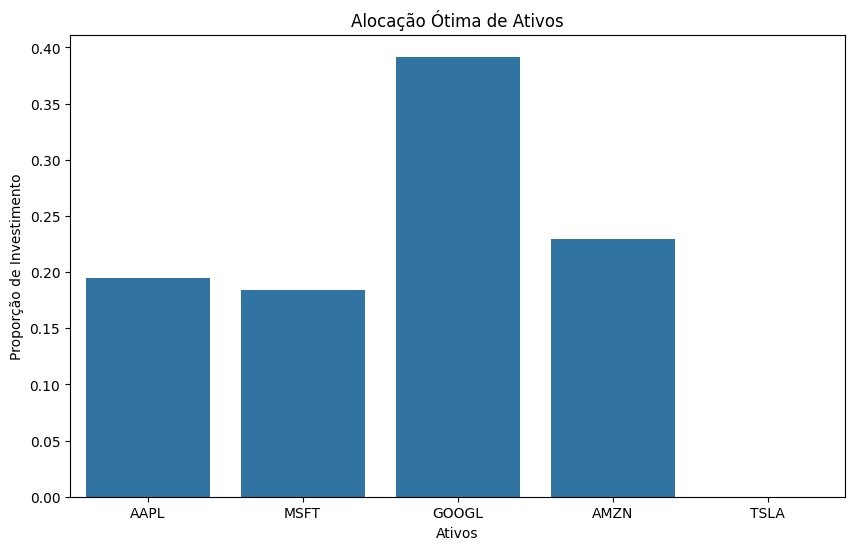

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Gráfico de barras para mostrar a alocação dos ativos
plt.figure(figsize=(10, 6))
sns.barplot(x=ativos, y=pesos_otimos)
plt.title('Alocação Ótima de Ativos')
plt.ylabel('Proporção de Investimento')
plt.xlabel('Ativos')
plt.show()

### 2. Gráfico da Fronteira Eficiente

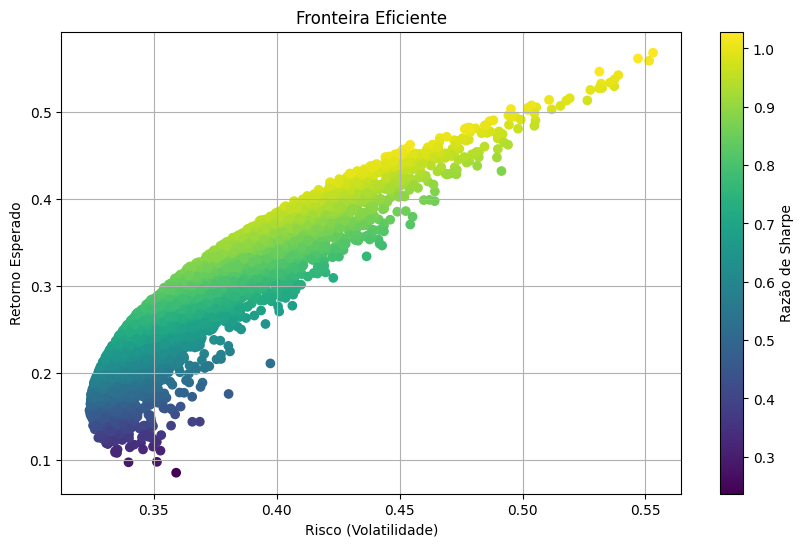

In [21]:
def fronteira_eficiente(retornos_diarios, num_portfolios=10000):
    np.random.seed(42)
    n_ativos = len(retornos_diarios.columns)
    resultados = np.zeros((3, num_portfolios))
    pesos_registrados = []

    for i in range(num_portfolios):
        # Gera pesos aleatórios
        pesos = np.random.random(n_ativos)
        pesos /= np.sum(pesos)  # Normaliza para que a soma dos pesos seja 1
        pesos_registrados.append(pesos)

        # Calcula o retorno esperado e a volatilidade para cada portfólio
        retorno_portfolio = np.sum(pesos * retorno_esperado)
        risco_portfolio = np.sqrt(np.dot(pesos.T, np.dot(cov_matrix, pesos)))

        # Registra o retorno, risco e a razão de Sharpe
        resultados[0,i] = retorno_portfolio
        resultados[1,i] = risco_portfolio
        resultados[2,i] = retorno_portfolio / risco_portfolio  # Razão de Sharpe

    return resultados, pesos_registrados

# Gerar a fronteira eficiente
resultados, pesos_registrados = fronteira_eficiente(retornos_diarios)

# Plotar a fronteira eficiente
plt.figure(figsize=(10, 6))
plt.scatter(resultados[1,:], resultados[0,:], c=resultados[2,:], cmap='viridis')
plt.colorbar(label='Razão de Sharpe')
plt.title('Fronteira Eficiente')
plt.xlabel('Risco (Volatilidade)')
plt.ylabel('Retorno Esperado')
plt.grid(True)
plt.show()


### 3. Gráfico de Distribuição de Ativos

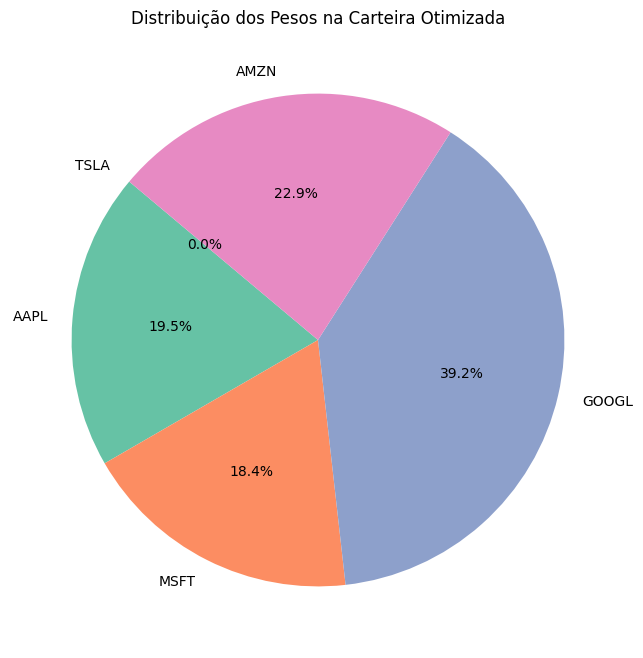

In [22]:
# Gráfico de Pizza para a distribuição dos ativos
plt.figure(figsize=(8, 8))
plt.pie(pesos_otimos, labels=ativos, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set2'))
plt.title('Distribuição dos Pesos na Carteira Otimizada')
plt.show()


### 4. Gráfico de Evolução do Retorno e Risco

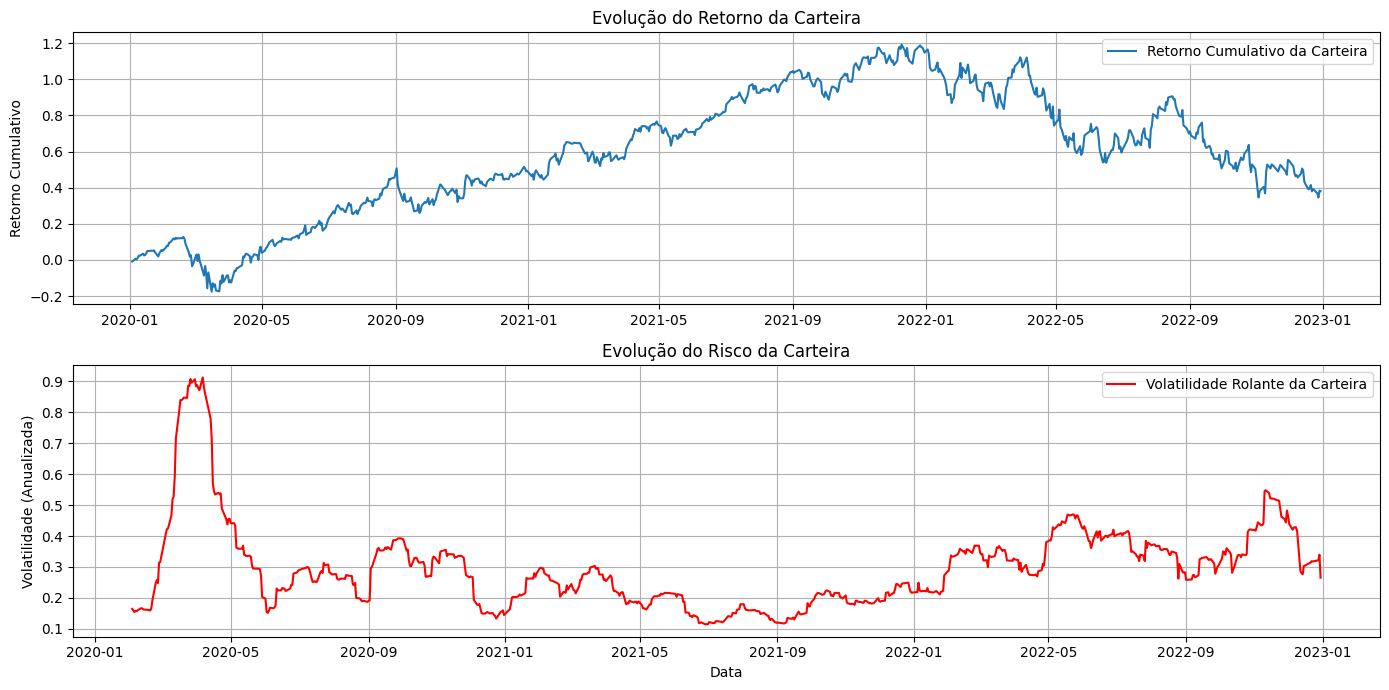

In [23]:
# Calcular a evolução de retornos e risco ao longo do tempo
retornos_diarios['Portfolio'] = retornos_diarios.dot(pesos_otimos)  # Retornos do portfólio
cumulative_returns = (1 + retornos_diarios['Portfolio']).cumprod() - 1  # Retorno cumulativo
rolling_volatility = retornos_diarios['Portfolio'].rolling(window=21).std() * (252 ** 0.5)  # Volatilidade rolante

# Plotar a evolução do retorno e risco
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(cumulative_returns, label='Retorno Cumulativo da Carteira')
plt.title('Evolução do Retorno da Carteira')
plt.ylabel('Retorno Cumulativo')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(rolling_volatility, color='red', label='Volatilidade Rolante da Carteira')
plt.title('Evolução do Risco da Carteira')
plt.ylabel('Volatilidade (Anualizada)')
plt.xlabel('Data')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
